# Use TD3 to Play Pendulum-v0

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Pendulum-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

17:58:31 [INFO] env: <PendulumEnv<Pendulum-v0>>
17:58:31 [INFO] action_space: Box(-2.0, 2.0, (1,), float32)
17:58:31 [INFO] observation_space: Box(-8.0, 8.0, (3,), float32)
17:58:31 [INFO] reward_range: (-inf, inf)
17:58:31 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
17:58:31 [INFO] _max_episode_steps: 200
17:58:31 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, x0):
        self.x = x0

    def __call__(self, mu=0., sigma=1., theta=.15, dt=.01):
        n = np.random.normal(size=self.x.shape)
        self.x += (theta * (mu - self.x) * dt + sigma * np.sqrt(dt) * n)
        return self.x

In [5]:
class TD3Agent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = 0.99

        self.replayer = DQNReplayer(20000)

        self.actor_evaluate_net = self.build_net(
                input_size=state_dim, hidden_sizes=[32, 64],
                output_size=self.action_dim, output_activation=nn.tanh)
        self.actor_target_net = models.clone_model(self.actor_evaluate_net)
        self.actor_target_net.set_weights(self.actor_evaluate_net.get_weights())

        self.critic0_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic0_target_net = models.clone_model(self.critic0_evaluate_net)
        self.critic0_target_net.set_weights(self.critic0_evaluate_net.get_weights())

        self.critic1_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic1_target_net = models.clone_model(self.critic1_evaluate_net)
        self.critic1_target_net.set_weights(self.critic1_evaluate_net.get_weights())

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1, 
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if layer == 0 else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, **kwargs))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.noise = OrnsteinUhlenbeckProcess(np.zeros((self.action_dim,)))

    def step(self, observation, reward, done):
        if self.mode == 'train' and self.replayer.count < 3000:
            action = np.random.uniform(self.action_low, self.action_high)
        else:
            action = self.actor_evaluate_net.predict(observation[np.newaxis])[0]
        if self.mode == 'train':
            noise = self.noise(sigma=0.1)
            action = (action + noise).clip(self.action_low, self.action_high)

            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            
            if self.replayer.count >= 3000:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = self.replayer.sample(64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        
        # learn critic
        next_actions = self.actor_target_net.predict(next_states)
        next_noises = np.random.normal(0, 0.2, size=next_actions.shape)
        next_actions = (next_actions + next_noises).clip(self.action_low, self.action_high)
        state_actions = np.hstack([states, actions])
        next_state_actions = np.hstack([next_states, next_actions])
        next_q0s = self.critic0_target_net.predict(next_state_actions)[:, 0]
        next_q1s = self.critic1_target_net.predict(next_state_actions)[:, 0]
        next_qs = np.minimum(next_q0s, next_q1s)
        targets = rewards + (1. - dones) * self.gamma * next_qs
        self.critic0_evaluate_net.fit(state_actions, targets[:, np.newaxis], verbose=0)
        self.critic1_evaluate_net.fit(state_actions, targets[:, np.newaxis], verbose=0)

        # learn actor
        with tf.GradientTape() as tape:
            action_tensor = self.actor_evaluate_net(state_tensor)
            state_action_tensor = tf.concat([state_tensor, action_tensor], axis=1)
            q_tensor = self.critic0_evaluate_net(state_action_tensor)
            loss_tensor = -tf.reduce_mean(q_tensor)
        grad_tensors = tape.gradient(loss_tensor, self.actor_evaluate_net.variables)
        self.actor_evaluate_net.optimizer.apply_gradients(zip(
                grad_tensors, self.actor_evaluate_net.variables))

        self.update_net(self.critic0_target_net, self.critic0_evaluate_net)
        self.update_net(self.critic1_target_net, self.critic1_evaluate_net)
        self.update_net(self.actor_target_net, self.actor_evaluate_net)


agent = TD3Agent(env)

17:58:32 [INFO] ==== train ====
17:58:32 [DEBUG] train episode 0: reward = -1779.61, steps = 200
17:58:32 [DEBUG] train episode 1: reward = -1026.05, steps = 200
17:58:33 [DEBUG] train episode 2: reward = -1556.83, steps = 200
17:58:33 [DEBUG] train episode 3: reward = -1127.41, steps = 200
17:58:33 [DEBUG] train episode 4: reward = -1675.42, steps = 200
17:58:33 [DEBUG] train episode 5: reward = -1632.59, steps = 200
17:58:33 [DEBUG] train episode 6: reward = -750.72, steps = 200
17:58:33 [DEBUG] train episode 7: reward = -1794.28, steps = 200
17:58:33 [DEBUG] train episode 8: reward = -928.49, steps = 200
17:58:34 [DEBUG] train episode 9: reward = -1680.41, steps = 200
17:58:34 [DEBUG] train episode 10: reward = -1312.04, steps = 200
17:58:34 [DEBUG] train episode 11: reward = -873.37, steps = 200
17:58:34 [DEBUG] train episode 12: reward = -1509.77, steps = 200
17:58:34 [DEBUG] train episode 13: reward = -994.03, steps = 200
17:58:34 [DEBUG] train episode 14: reward = -909.50, steps

22:34:57 [DEBUG] train episode 125: reward = -368.06, steps = 200
22:37:33 [DEBUG] train episode 126: reward = -126.63, steps = 200
22:40:22 [DEBUG] train episode 127: reward = -126.61, steps = 200
22:42:53 [DEBUG] train episode 128: reward = -122.34, steps = 200
22:45:16 [DEBUG] train episode 129: reward = -355.01, steps = 200
22:47:50 [DEBUG] train episode 130: reward = -2.74, steps = 200
22:50:30 [DEBUG] train episode 131: reward = -362.53, steps = 200
22:53:18 [DEBUG] train episode 132: reward = -124.13, steps = 200
22:56:52 [DEBUG] train episode 133: reward = -243.08, steps = 200
23:00:16 [DEBUG] train episode 134: reward = -509.38, steps = 200
23:02:50 [DEBUG] train episode 135: reward = -541.73, steps = 200
23:05:14 [DEBUG] train episode 136: reward = -240.73, steps = 200
23:07:31 [DEBUG] train episode 137: reward = -484.19, steps = 200
23:09:54 [DEBUG] train episode 138: reward = -244.57, steps = 200
23:12:33 [DEBUG] train episode 139: reward = -361.16, steps = 200
23:14:52 [DE

02:10:09 [DEBUG] test episode 40: reward = -357.19, steps = 200
02:11:13 [DEBUG] test episode 41: reward = -125.26, steps = 200
02:12:19 [DEBUG] test episode 42: reward = -510.98, steps = 200
02:13:25 [DEBUG] test episode 43: reward = -122.92, steps = 200
02:14:30 [DEBUG] test episode 44: reward = -352.75, steps = 200
02:15:34 [DEBUG] test episode 45: reward = -235.63, steps = 200
02:16:39 [DEBUG] test episode 46: reward = -124.38, steps = 200
02:17:41 [DEBUG] test episode 47: reward = -123.12, steps = 200
02:18:46 [DEBUG] test episode 48: reward = -356.79, steps = 200
02:19:50 [DEBUG] test episode 49: reward = -122.82, steps = 200
02:20:55 [DEBUG] test episode 50: reward = -482.93, steps = 200
02:21:59 [DEBUG] test episode 51: reward = -123.72, steps = 200
02:23:04 [DEBUG] test episode 52: reward = -1.34, steps = 200
02:24:10 [DEBUG] test episode 53: reward = -242.64, steps = 200
02:25:14 [DEBUG] test episode 54: reward = -357.67, steps = 200
02:26:20 [DEBUG] test episode 55: reward =

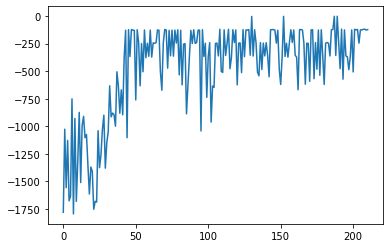

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -150:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()